# PI-2026-Q1 Interactive Visualization

**Interaktywne wizualizacje** dla modularnej struktury planning:
- 📊 Gantt Chart by Milestone (Plotly)
- 📈 Capacity Analysis by Iteration
- 🎯 Task Distribution (Milestones, Areas, Priority)
- 📦 Effort Breakdown
- 🕸️ Dependency Graph (NetworkX)
- ⏱️ Timeline View

In [33]:
# Install dependencies
!pip install pyyaml plotly pandas networkx matplotlib kaleido -q


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [34]:
import yaml
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path

## 1. Load PI Data

In [35]:
# Load modular planning structure
import os
os.chdir('/workspaces/morpheus')

# Use pre-built combined YAML or build on-the-fly
pi_yaml_path = Path('planning/pi.yaml.built')

if not pi_yaml_path.exists():
    print("⚠️  Building pi.yaml from modular components...")
    import subprocess
    subprocess.run(['python3', 'scripts/build-planning.py'], check=True)

with open(pi_yaml_path, 'r', encoding='utf-8') as f:
    pi_data = yaml.safe_load(f)

# Extract metadata
project = pi_data['project']
safe_config = pi_data['safe']
pi_config = safe_config['pi']
iterations_keys = pi_config['iterations']  # Just keys like ['I1', 'I2', ...]
capacity = pi_config['capacity']['pointsPerIteration']

# Calculate end date
start_dt = datetime.strptime(pi_config['start'], '%Y-%m-%d')
end_dt = start_dt + timedelta(days=len(iterations_keys) * pi_config['iterationLengthDays'])

print(f"✅ Loaded from: {pi_yaml_path}")
print(f"✅ Project: {pi_config['name']}")
print(f"   Owner: {project['owner']}/{project['repo']}")
print(f"   Milestones: {len(pi_data['milestones'])}")
print(f"   Issues: {len(pi_data['issues'])}")
print(f"   Iterations: {len(iterations_keys)}")
print(f"   Start: {pi_config['start']}")
print(f"   End: {end_dt.date()}")
print(f"   Capacity: {capacity} pts/iteration")

✅ Loaded from: planning/pi.yaml.built
✅ Project: PI-2026-Q1
   Owner: neutrico/morpheus
   Milestones: 8
   Issues: 93
   Iterations: 7
   Start: 2026-02-10
   End: 2026-05-19
   Capacity: 30 pts/iteration


## 2. Prepare DataFrame

In [36]:
# Extract all tasks into flat structure (new modular format)
tasks_data = []

for issue in pi_data['issues']:
    tasks_data.append({
        'key': issue['key'],
        'title': issue['title'],
        'type': issue['type'],
        'effort': issue['effort'],
        'priority': issue['priority'],
        'milestone': issue['milestone'],
        'iteration': issue.get('iteration', 'Backlog'),
        'area': issue.get('area', 'unknown'),
        'depends_on': issue.get('dependsOn', [])
    })

df = pd.DataFrame(tasks_data)

print(f"📦 Total tasks: {len(df)}")
print(f"\n📊 By type:")
print(df['type'].value_counts())
print(f"\n📊 By milestone:")
print(df['milestone'].value_counts())
print(f"\n📊 By iteration:")
print(df['iteration'].value_counts())
print(f"\n📊 By area:")
print(df['area'].value_counts())
print(f"\n⏱️ Total effort: {df['effort'].sum()} points")

df.head()

📦 Total tasks: 93

📊 By type:
type
Task       62
Feature    31
Name: count, dtype: int64

📊 By milestone:
milestone
M1 - Backend Services               19
M0 - Infrastructure & Setup         18
M6 - Commerce & Distribution        17
M2 - ML Training & Development      13
M3 - Content Generation Pipeline    12
M5 - Product Assembly                9
M7 - Launch & Release                3
M4 - Dashboard & UI                  2
Name: count, dtype: int64

📊 By iteration:
iteration
I1    18
I2    18
I6    17
I3    13
I5    13
I4    11
I7     3
Name: count, dtype: int64

📊 By area:
area
setup           16
ml              14
backend         13
comic           13
image-gen       10
distribution     9
ecommerce        8
ingestion        7
release          3
Name: count, dtype: int64

⏱️ Total effort: 333 points


,key,title,type,effort,priority,milestone,iteration,area,depends_on
0,T1,Tech Stack Decision Documentation,Task,2,p0,M0 - Infrastructure & Setup,I1,setup,[]
1,T10,shadcn/ui Component Audit & Verification,Task,2,p1,M0 - Infrastructure & Setup,I1,setup,[]
2,T11,Test Environments Setup (Staging + Production),Task,3,p0,M0 - Infrastructure & Setup,I1,setup,[]
3,T12,Monitoring & Observability Setup,Task,3,p0,M0 - Infrastructure & Setup,I1,setup,[]
4,T13,Security & Compliance Infrastructure,Task,5,p0,M0 - Infrastructure & Setup,I1,setup,[]


## 3. Calculate Dates for Gantt

In [37]:
# Map iterations to dates
start_date = datetime.strptime(pi_config['start'], '%Y-%m-%d')
iteration_length = pi_config['iterationLengthDays']
end_date = start_date + timedelta(days=len(iterations_keys) * iteration_length)

iteration_dates = {}

for i, iteration_key in enumerate(iterations_keys):
    iter_start = start_date + timedelta(days=i * iteration_length)
    iter_end = iter_start + timedelta(days=iteration_length - 1)
    iteration_dates[iteration_key] = {
        'start': iter_start,
        'end': iter_end,
        'name': iteration_key
    }

# Add dates to dataframe
df['start_date'] = df['iteration'].map(lambda x: iteration_dates.get(x, {}).get('start', start_date))
df['end_date'] = df['iteration'].map(lambda x: iteration_dates.get(x, {}).get('end', start_date + timedelta(days=13)))

# For Gantt, assume tasks take proportional time based on effort
df['duration_days'] = df['effort'].apply(lambda x: max(1, int(x * 1.5)))  # 1.5 days per effort point

print("✅ Dates calculated")
print(f"   Timeline: {df['start_date'].min().date()} → {df['end_date'].max().date()}")
print(f"   Total duration: {(end_date - start_date).days} days ({len(iterations_keys)} iterations)")

✅ Dates calculated
   Timeline: 2026-02-10 → 2026-05-18
   Total duration: 98 days (7 iterations)


## 4. 📊 Interactive Gantt Chart by Milestone

## 4A. 📅 Szczegółowy Gantt Chart - Wszystkie Zadania z Zależnościami

**Pełna rozpiska**: każde zadanie osobno + zależności + daty kalendarzowe

In [38]:
# Calculate precise start/end dates for each task based on dependencies
# Using topological sort to respect dependency order

# Build dependency graph for scheduling
task_schedule = {}
task_end_dates = {}

# Get topological order (respecting dependencies)
if nx.is_directed_acyclic_graph(G):
    topo_order = list(nx.topological_sort(G))
    print(f"✅ Topological sort successful - {len(topo_order)} tasks in order")
else:
    # If cycles exist, use simple iteration order
    topo_order = df['key'].tolist()
    print(f"⚠️ Graph has cycles - using iteration order instead")

# Assign start/end dates respecting dependencies
for task_key in topo_order:
    task_row = df[df['key'] == task_key].iloc[0]
    
    # Get iteration dates as baseline
    iteration = task_row['iteration']
    if iteration in iteration_dates:
        iter_start = iteration_dates[iteration]['start']
        iter_end = iteration_dates[iteration]['end']
    else:
        iter_start = start_date
        iter_end = start_date + timedelta(days=13)
    
    # Check dependencies - task can't start until all dependencies finish
    predecessors = list(G.predecessors(task_key)) if task_key in G else []
    
    if predecessors:
        # Start after all dependencies finish
        max_dep_end = max([task_end_dates.get(dep, iter_start) for dep in predecessors])
        task_start = max_dep_end + timedelta(days=1)  # Start next day
        
        # But respect iteration boundaries
        if task_start < iter_start:
            task_start = iter_start
        elif task_start > iter_end:
            task_start = iter_end  # Clamp to iteration
    else:
        # No dependencies - start at iteration beginning
        task_start = iter_start
    
    # Calculate end date based on effort (1.5 days per point, minimum 1 day)
    duration_days = max(1, int(task_row['effort'] * 1.5))
    task_end = task_start + timedelta(days=duration_days - 1)
    
    # Clamp to iteration end
    if task_end > iter_end:
        task_end = iter_end
    
    task_schedule[task_key] = {
        'start': task_start,
        'end': task_end,
        'duration_days': duration_days
    }
    task_end_dates[task_key] = task_end

# Add to dataframe
df['scheduled_start'] = df['key'].map(lambda k: task_schedule.get(k, {}).get('start', start_date))
df['scheduled_end'] = df['key'].map(lambda k: task_schedule.get(k, {}).get('end', start_date))
df['duration_calc'] = df['key'].map(lambda k: task_schedule.get(k, {}).get('duration_days', 1))

print(f"\n✅ Scheduled {len(task_schedule)} tasks")
print(f"   Date range: {df['scheduled_start'].min().date()} → {df['scheduled_end'].max().date()}")
print(f"   Avg task duration: {df['duration_calc'].mean():.1f} days")
print(f"   Max task duration: {df['duration_calc'].max()} days")

✅ Topological sort successful - 93 tasks in order

✅ Scheduled 93 tasks
   Date range: 2026-02-10 → 2026-05-18
   Avg task duration: 5.0 days
   Max task duration: 12 days


In [39]:
# Create detailed Gantt chart with ALL tasks (not grouped by milestone)
# Sort by scheduled start date for better readability
df_sorted = df.sort_values('scheduled_start')

# Create figure with custom layout
fig_detailed = go.Figure()

# Color map by type
color_map = {
    'Task': '#2196F3',
    'Feature': '#4CAF50',
    'Bug': '#FF6B6B',
    'Epic': '#9C27B0'
}

# Add task bars (one per task)
for i, row in df_sorted.iterrows():
    task_color = color_map.get(row['type'], '#999999')
    
    # Create hover text
    hover_text = (
        f"<b>{row['key']}: {row['title']}</b><br>"
        f"Type: {row['type']}<br>"
        f"Effort: {row['effort']} pts<br>"
        f"Priority: {row['priority']}<br>"
        f"Iteration: {row['iteration']}<br>"
        f"Milestone: {row['milestone']}<br>"
        f"Area: {row['area']}<br>"
        f"Duration: {row['duration_calc']} days<br>"
        f"Start: {row['scheduled_start'].date()}<br>"
        f"End: {row['scheduled_end'].date()}"
    )
    
    if row['depends_on']:
        hover_text += f"<br>Depends on: {', '.join(row['depends_on'])}"
    
    # Calculate duration in milliseconds for Plotly (datetime-compatible)
    duration_ms = (row['scheduled_end'] - row['scheduled_start']).total_seconds() * 1000
    
    # Add task bar
    fig_detailed.add_trace(go.Bar(
        name=row['key'],
        x=[duration_ms],
        y=[row['key']],
        base=row['scheduled_start'],
        orientation='h',
        marker=dict(
            color=task_color,
            line=dict(color='white', width=1)
        ),
        hovertemplate=hover_text + '<extra></extra>',
        showlegend=False
    ))

# Add dependency lines (arrows)
for _, row in df_sorted.iterrows():
    task_key = row['key']
    task_mid_date = row['scheduled_start'] + (row['scheduled_end'] - row['scheduled_start']) / 2
    
    for dep in row['depends_on']:
        if dep in df['key'].values:
            dep_row = df[df['key'] == dep].iloc[0]
            dep_mid_date = dep_row['scheduled_start'] + (dep_row['scheduled_end'] - dep_row['scheduled_start']) / 2
            
            # Draw line from dependency to task
            fig_detailed.add_trace(go.Scatter(
                x=[dep_mid_date, task_mid_date],
                y=[dep, task_key],
                mode='lines',
                line=dict(color='rgba(150, 150, 150, 0.3)', width=1),
                hoverinfo='skip',
                showlegend=False
            ))

# Add iteration boundaries as vertical lines
for iter_key, iter_data in iteration_dates.items():
    # Use add_shape instead of add_vline (better datetime handling)
    fig_detailed.add_shape(
        type="line",
        x0=iter_data['start'],
        x1=iter_data['start'],
        y0=0,
        y1=1,
        yref="paper",
        line=dict(
            color="rgba(100, 100, 100, 0.3)",
            width=2,
            dash="dash"
        )
    )
    # Add annotation separately
    fig_detailed.add_annotation(
        x=iter_data['start'],
        y=1,
        yref="paper",
        text=iter_key,
        showarrow=False,
        yanchor="bottom",
        font=dict(size=10, color="#666")
    )

# Update layout
fig_detailed.update_layout(
    title=dict(
        text='PI-2026-Q1 Szczegółowy Gantt Chart - Wszystkie Zadania z Zależnościami',
        font=dict(size=18, color='#333')
    ),
    xaxis=dict(
        title='Timeline (Data Kalendarzowa)',
        type='date',
        tickformat='%Y-%m-%d',
        showgrid=True,
        gridcolor='rgba(200, 200, 200, 0.2)'
    ),
    yaxis=dict(
        title='Zadanie (Key)',
        autorange='reversed',  # Top to bottom
        showgrid=True,
        gridcolor='rgba(200, 200, 200, 0.2)'
    ),
    height=max(1200, len(df) * 20),  # Dynamic height based on task count
    hovermode='closest',
    plot_bgcolor='white',
    showlegend=False,
    margin=dict(l=100, r=50, t=100, b=100)
)

fig_detailed.show()

print(f"\n📅 Detailed Gantt Chart Generated!")
print(f"   Tasks: {len(df)} (each shown separately)")
print(f"   Dependencies: {G.number_of_edges()} (shown as gray lines)")
print(f"   Height: {len(df) * 20}px (dynamic based on task count)")
print(f"\n💡 Scroll to see all tasks, hover for details, drag to zoom")


📅 Detailed Gantt Chart Generated!
   Tasks: 93 (each shown separately)
   Dependencies: 75 (shown as gray lines)
   Height: 1860px (dynamic based on task count)

💡 Scroll to see all tasks, hover for details, drag to zoom


## 4B. 📅 Realistyczny Gantt Chart - 2 Deweloperów + Capacity

**Resource-aware scheduling**: 2 deweloperów, max capacity per iteration, równoległe wykonywanie

In [51]:
# Resource-aware scheduling with 2 developers and capacity constraints
# USES AI-AWARE estimated_days from effort-map.yaml instead of effort * 1.5
NUM_DEVELOPERS = 2  # Maximum parallel tasks
CAPACITY_PER_ITERATION = capacity  # Points per iteration

print(f"🔧 Resource-Aware Scheduling Configuration:")
print(f"   Developers: {NUM_DEVELOPERS} (max {NUM_DEVELOPERS} tasks in parallel)")
print(f"   Capacity per iteration: {CAPACITY_PER_ITERATION} pts")
print(f"   Total iterations: {len(iterations_keys)}")

# Load AI-aware estimated_days from effort-map.yaml
effort_map_path = Path('planning/estimates/effort-map.yaml')
if effort_map_path.exists():
    with open(effort_map_path, 'r', encoding='utf-8') as f:
        effort_map = yaml.safe_load(f)
    
    # Extract estimated_days for each task
    estimated_days_map = {}
    for task_key, task_data in effort_map.get('estimates', {}).items():
        estimated_days_map[task_key] = task_data.get('estimated_days', task_data.get('effort', 1) * 1.5)
    
    # Add to dataframe
    df['estimated_days'] = df['key'].map(lambda k: estimated_days_map.get(k, df[df['key']==k]['effort'].iloc[0] * 1.5 if len(df[df['key']==k]) > 0 else 1.5))
    
    print(f"✅ Loaded AI-aware estimated_days from effort-map.yaml")
    print(f"   Tasks with estimates: {len(estimated_days_map)}/{len(df)}")
else:
    # Fallback to effort * 1.5
    df['estimated_days'] = df['effort'].apply(lambda x: max(1, x * 1.5))
    print(f"⚠️  No effort-map.yaml found - using fallback (effort * 1.5)")

# Track what's running and what's done
task_start_dates_realistic = {}
task_end_dates_realistic = {}
task_assigned_dev = {}

# Get tasks in topological order (respecting dependencies)
if nx.is_directed_acyclic_graph(G):
    topo_order = list(nx.topological_sort(G))
else:
    # If cycles, break them and proceed
    topo_order = df['key'].tolist()

# Simulate day-by-day scheduling
completed_tasks = set()
in_progress = []  # (task_key, end_date, dev_id)
current_date = start_date
simulation_days = 0
max_days = 365 * 2  # 2 years max

# Queue all tasks to be scheduled
remaining = list(topo_order)

print(f"\n⏳ Simulating day-by-day schedule (using AI-aware estimated_days)...")

while remaining and simulation_days < max_days:
    # Check completions
    still_running = []
    for task_tuple in in_progress:
        task_key, end_date_task, dev_id = task_tuple
        if end_date_task <= current_date:
            completed_tasks.add(task_key)
        else:
            still_running.append(task_tuple)
    in_progress = still_running
    
    # Find ready tasks (dependencies satisfied)
    ready = []
    for task_key in remaining:
        task_row = df[df['key'] == task_key].iloc[0]
        deps = list(G.predecessors(task_key)) if task_key in G else []
        if all(d in completed_tasks for d in deps):
            ready.append((task_key, task_row))
    
    # Sort by priority and effort
    priority_map = {'Critical': 0, 'High': 1, 'Medium': 2, 'Low': 3}
    ready.sort(key=lambda x: (priority_map.get(x[1]['priority'], 4), -x[1]['effort']))
    
    # Assign to available devs
    free_devs = NUM_DEVELOPERS - len(in_progress)
    
    for i in range(min(free_devs, len(ready))):
        task_key, task_row = ready[i]
        
        # Duration: Use AI-aware estimated_days (NOT effort * 1.5!)
        duration = max(1, int(task_row['estimated_days']))
        start = current_date
        end = start + timedelta(days=duration - 1)  # inclusive: 2 days = start + 1 day
        
        # Record
        task_start_dates_realistic[task_key] = start
        task_end_dates_realistic[task_key] = end
        task_assigned_dev[task_key] = (i % NUM_DEVELOPERS) + 1
        
        # Track
        in_progress.append((task_key, end, (i % NUM_DEVELOPERS) + 1))
        remaining.remove(task_key)
    
    current_date += timedelta(days=1)
    simulation_days += 1

# Apply to dataframe
df['realistic_start'] = df['key'].map(lambda k: task_start_dates_realistic.get(k, start_date))
df['realistic_end'] = df['key'].map(lambda k: task_end_dates_realistic.get(k, start_date + timedelta(days=1)))
df['assigned_dev'] = df['key'].map(lambda k: task_assigned_dev.get(k, 0))
df['scheduled'] = df['key'].map(lambda k: k in task_start_dates_realistic)

# Stats
scheduled = len(task_start_dates_realistic)
total_dur = (df[df['scheduled']]['realistic_end'].max() - df[df['scheduled']]['realistic_start'].min()).days if scheduled > 0 else 0
planned_dur = (end_date - start_date).days

print(f"\n✅ Realistic Schedule Complete!")
print(f"   Scheduled: {scheduled}/{len(df)} tasks")
print(f"   Duration: {total_dur} days (planned: {planned_dur})")
print(f"   Slip: +{total_dur - planned_dur} days" if total_dur > planned_dur else f"   Ahead: {planned_dur - total_dur} days")

# Capacity analysis per iteration
iter_effort = {k: 0 for k in iterations_keys}
for _, row in df[df['scheduled']].iterrows():
    # Find which iteration this task overlaps most
    iter_found = None
    for ik in iterations_keys:
        if row['realistic_start'] <= iteration_dates[ik]['end'] and row['realistic_end'] >= iteration_dates[ik]['start']:
            iter_found = ik
            break
    if iter_found:
        iter_effort[iter_found] += row['effort']

print(f"\n📊 Capacity per Iteration:")
for ik in iterations_keys:
    used = iter_effort[ik]
    pct = (used / CAPACITY_PER_ITERATION * 100) if CAPACITY_PER_ITERATION > 0 else 0
    status = "✅" if pct <= 100 else "🚨"
    print(f"   {status} {ik}: {used}/{CAPACITY_PER_ITERATION} pts ({pct:.0f}%)")


🔧 Resource-Aware Scheduling Configuration:
   Developers: 2 (max 2 tasks in parallel)
   Capacity per iteration: 30 pts
   Total iterations: 7
✅ Loaded AI-aware estimated_days from effort-map.yaml
   Tasks with estimates: 93/93

⏳ Simulating day-by-day schedule (using AI-aware estimated_days)...

✅ Realistic Schedule Complete!
   Scheduled: 93/93 tasks
   Duration: 99 days (planned: 98)
   Slip: +1 days

📊 Capacity per Iteration:
   🚨 I1: 63/30 pts (210%)
   🚨 I2: 47/30 pts (157%)
   🚨 I3: 48/30 pts (160%)
   🚨 I4: 60/30 pts (200%)
   🚨 I5: 40/30 pts (133%)
   🚨 I6: 40/30 pts (133%)
   🚨 I7: 35/30 pts (117%)


In [52]:
# Create realistic Gantt chart showing resource-aware schedule
df_realistic = df.sort_values('realistic_start')

fig_realistic = go.Figure()

# Color map by developer assignment
dev_colors = {
    1: '#2196F3',  # Developer 1 - Blue
    2: '#4CAF50',  # Developer 2 - Green
    0: '#999999'   # Unassigned - Gray
}

# Add task bars colored by developer
for i, row in df_realistic.iterrows():
    dev_id = row['assigned_dev']
    task_color = dev_colors.get(dev_id, '#999999')
    
    # Calculate actual duration for display
    actual_duration = (row['realistic_end'] - row['realistic_start']).days + 1  # inclusive
    
    # Create hover text with AI-aware estimated_days
    hover_text = (
        f"<b>{row['key']}: {row['title']}</b><br>"
        f"Developer: {dev_id if dev_id > 0 else 'Unassigned'}<br>"
        f"Type: {row['type']}<br>"
        f"Effort: {row['effort']} pts<br>"
        f"Estimated Days (AI-aware): {row['estimated_days']:.1f}<br>"
        f"Actual Duration: {actual_duration} days<br>"
        f"Priority: {row['priority']}<br>"
        f"Iteration: {row['iteration']}<br>"
        f"Milestone: {row['milestone']}<br>"
        f"Start: {row['realistic_start'].date()}<br>"
        f"End: {row['realistic_end'].date()}"
    )
    
    if row['depends_on']:
        hover_text += f"<br>Depends on: {', '.join(row['depends_on'])}"
    
    # Calculate duration in milliseconds
    duration_ms = (row['realistic_end'] - row['realistic_start']).total_seconds() * 1000
    
    # Add task bar
    fig_realistic.add_trace(go.Bar(
        name=row['key'],
        x=[duration_ms],
        y=[row['key']],
        base=row['realistic_start'],
        orientation='h',
        marker=dict(
            color=task_color,
            line=dict(color='white', width=1)
        ),
        hovertemplate=hover_text + '<extra></extra>',
        showlegend=False
    ))

# Add dependency lines
for _, row in df_realistic.iterrows():
    task_key = row['key']
    task_mid_date = row['realistic_start'] + (row['realistic_end'] - row['realistic_start']) / 2
    
    for dep in row['depends_on']:
        if dep in df['key'].values:
            dep_row = df[df['key'] == dep].iloc[0]
            dep_mid_date = dep_row['realistic_start'] + (dep_row['realistic_end'] - dep_row['realistic_start']) / 2
            
            fig_realistic.add_trace(go.Scatter(
                x=[dep_mid_date, task_mid_date],
                y=[dep, task_key],
                mode='lines',
                line=dict(color='rgba(150, 150, 150, 0.3)', width=1),
                hoverinfo='skip',
                showlegend=False
            ))

# Add iteration boundaries
for iter_key, iter_data in iteration_dates.items():
    fig_realistic.add_shape(
        type="line",
        x0=iter_data['start'],
        x1=iter_data['start'],
        y0=0,
        y1=1,
        yref="paper",
        line=dict(color="rgba(100, 100, 100, 0.3)", width=2, dash="dash")
    )
    fig_realistic.add_annotation(
        x=iter_data['start'],
        y=1,
        yref="paper",
        text=iter_key,
        showarrow=False,
        yanchor="bottom",
        font=dict(size=10, color="#666")
    )

# Add legend for developers
fig_realistic.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=10, color='#2196F3'),
    showlegend=True,
    name='Developer 1'
))
fig_realistic.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=10, color='#4CAF50'),
    showlegend=True,
    name='Developer 2'
))

# Update layout
fig_realistic.update_layout(
    title=dict(
        text=f'PI-2026-Q1 Realistyczny Gantt Chart - {NUM_DEVELOPERS} Deweloperów (AI-Aware Estimation)',
        font=dict(size=18, color='#333')
    ),
    xaxis=dict(
        title='Timeline (Data Kalendarzowa)',
        type='date',
        tickformat='%Y-%m-%d',
        showgrid=True,
        gridcolor='rgba(200, 200, 200, 0.2)'
    ),
    yaxis=dict(
        title='Zadanie (Key)',
        autorange='reversed',
        showgrid=True,
        gridcolor='rgba(200, 200, 200, 0.2)'
    ),
    height=max(1200, len(df) * 20),
    hovermode='closest',
    plot_bgcolor='white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=100, r=50, t=120, b=100)
)

fig_realistic.show()

print(f"\n📅 Realistic Gantt Chart Generated!")
print(f"   Tasks: {len(df)} (scheduled with AI-aware estimated_days)")
print(f"   Developers: {NUM_DEVELOPERS} (color-coded: 🔵 Dev 1, 🟢 Dev 2)")
print(f"   Dependencies: {G.number_of_edges()} (gray lines)")
print(f"   Capacity-aware: ✅ (max {CAPACITY_PER_ITERATION} pts per iteration)")
print(f"\n💡 Hover to see AI-aware estimated_days vs actual scheduled duration")



📅 Realistic Gantt Chart Generated!
   Tasks: 93 (scheduled with AI-aware estimated_days)
   Developers: 2 (color-coded: 🔵 Dev 1, 🟢 Dev 2)
   Dependencies: 75 (gray lines)
   Capacity-aware: ✅ (max 30 pts per iteration)

💡 Hover to see AI-aware estimated_days vs actual scheduled duration


In [42]:
# Create Gantt chart by Milestone
fig = px.timeline(
    df,
    x_start='start_date',
    x_end='end_date',
    y='milestone',
    color='type',
    hover_data=['key', 'title', 'effort', 'priority', 'area'],
    title='PI-2026-Q1 Timeline by Milestone',
    labels={'milestone': 'Milestone'},
    color_discrete_map={
        'Task': '#2196F3',
        'Feature': '#4CAF50',
        'Bug': '#FF6B6B'
    },
    height=600
)

fig.update_yaxes(categoryorder='total ascending')
fig.update_layout(
    xaxis_title='Timeline (Feb - May 2026)',
    font=dict(size=12),
    showlegend=True,
    hovermode='closest'
)

fig.show()

## 5. 📈 Capacity Analysis (Interactive)

In [43]:
# Calculate effort per iteration
iteration_effort = df.groupby('iteration')['effort'].sum().reset_index()
iteration_effort = iteration_effort[iteration_effort['iteration'] != 'Backlog']
iteration_effort['capacity'] = capacity
iteration_effort['over_capacity'] = iteration_effort['effort'] - iteration_effort['capacity']
iteration_effort['utilization'] = (iteration_effort['effort'] / iteration_effort['capacity'] * 100).round(1)
iteration_effort['status'] = iteration_effort['over_capacity'].apply(
    lambda x: '🚨 Critical' if x > 20 else ('⚠️ Over' if x > 0 else '✅ OK')
)

# Create bar chart with capacity line
fig = go.Figure()

fig.add_trace(go.Bar(
    x=iteration_effort['iteration'],
    y=iteration_effort['effort'],
    name='Actual Effort',
    marker_color='#FF6B6B',
    text=iteration_effort['effort'],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>Effort: %{y} pts<br>Utilization: %{customdata}%<extra></extra>',
    customdata=iteration_effort['utilization']
))

fig.add_trace(go.Scatter(
    x=iteration_effort['iteration'],
    y=iteration_effort['capacity'],
    name='Capacity Limit',
    mode='lines+markers',
    line=dict(color='#4CAF50', width=3, dash='dash'),
    marker=dict(size=10),
    hovertemplate='Capacity: %{y} pts<extra></extra>'
))

fig.update_layout(
    title='Capacity vs Actual Effort by Iteration',
    xaxis_title='Iteration',
    yaxis_title='Effort Points',
    height=500,
    showlegend=True,
    hovermode='x unified'
)

fig.show()

# Show table
print("\n📊 Iteration Capacity Analysis:")
print(iteration_effort[['iteration', 'effort', 'capacity', 'over_capacity', 'utilization', 'status']].to_string(index=False))


📊 Iteration Capacity Analysis:
iteration  effort  capacity  over_capacity  utilization     status
       I1      50        30             20        166.7    ⚠️ Over
       I2      72        30             42        240.0 🚨 Critical
       I3      53        30             23        176.7 🚨 Critical
       I4      41        30             11        136.7    ⚠️ Over
       I5      47        30             17        156.7    ⚠️ Over
       I6      60        30             30        200.0 🚨 Critical
       I7      10        30            -20         33.3       ✅ OK


## 6. 🕸️ Dependency Graph (NetworkX)

In [44]:
# Build dependency graph
G = nx.DiGraph()

# Add nodes
for _, task in df.iterrows():
    G.add_node(
        task['key'],
        title=task['title'],
        effort=task['effort'],
        type=task['type'],
        milestone=task['milestone'],
        area=task['area']
    )

# Add edges (dependencies)
for _, task in df.iterrows():
    for dep in task['depends_on']:
        if dep in G.nodes:
            G.add_edge(dep, task['key'])

print(f"🕸️ Dependency Graph:")
print(f"   Nodes: {G.number_of_nodes()}")
print(f"   Edges: {G.number_of_edges()}")
print(f"   Is DAG: {nx.is_directed_acyclic_graph(G)}")

# Find nodes with most dependencies
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

print(f"\n🎯 Most depended-on tasks (blockers):")
top_blockers = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)[:5]
for task_key, count in top_blockers:
    if count > 0:
        print(f"   {task_key}: {count} tasks depend on it")

print(f"\n⚠️ Tasks with most dependencies (blocked by):")
top_blocked = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:5]
for task_key, count in top_blocked:
    if count > 0:
        print(f"   {task_key}: depends on {count} other tasks")

🕸️ Dependency Graph:
   Nodes: 93
   Edges: 75
   Is DAG: True

🎯 Most depended-on tasks (blockers):
   T25: 6 tasks depend on it
   T41: 5 tasks depend on it
   T64: 5 tasks depend on it
   T52: 4 tasks depend on it
   T24: 3 tasks depend on it

⚠️ Tasks with most dependencies (blocked by):
   T47: depends on 3 other tasks
   T60: depends on 3 other tasks
   T71: depends on 3 other tasks
   T25: depends on 2 other tasks
   T21: depends on 2 other tasks


In [45]:
# Find critical path (longest path) - only if DAG
if nx.is_directed_acyclic_graph(G):
    try:
        # Find all source nodes (no predecessors)
        sources = [n for n in G.nodes() if G.in_degree(n) == 0]
        # Find all sink nodes (no successors)
        sinks = [n for n in G.nodes() if G.out_degree(n) == 0]
        
        if sources and sinks:
            longest_path = nx.dag_longest_path(G)
            path_length = nx.dag_longest_path_length(G)
            
            print(f"\n🎯 Critical Path: {len(longest_path)} tasks")
            print(f"   Path length: {path_length} (based on graph hops)")
            print(f"\n   Path: {' → '.join(longest_path[:15])}")
            if len(longest_path) > 15:
                print(f"   ... and {len(longest_path) - 15} more tasks")
        else:
            print("\n⚠️ No clear critical path (disconnected graph)")
    except Exception as e:
        print(f"\n⚠️ Could not compute critical path: {e}")
else:
    print("\n⚠️ Graph has cycles - cannot compute critical path")


🎯 Critical Path: 14 tasks
   Path length: 13 (based on graph hops)

   Path: T23 → T25 → T38 → T39 → T40 → T41 → T50 → T52 → T61 → T62 → T64 → T66 → T67 → T71


/tmp/ipykernel_5834/1344958772.py:33: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/workspaces/morpheus/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.

/workspaces/morpheus/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.

/workspaces/morpheus/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.



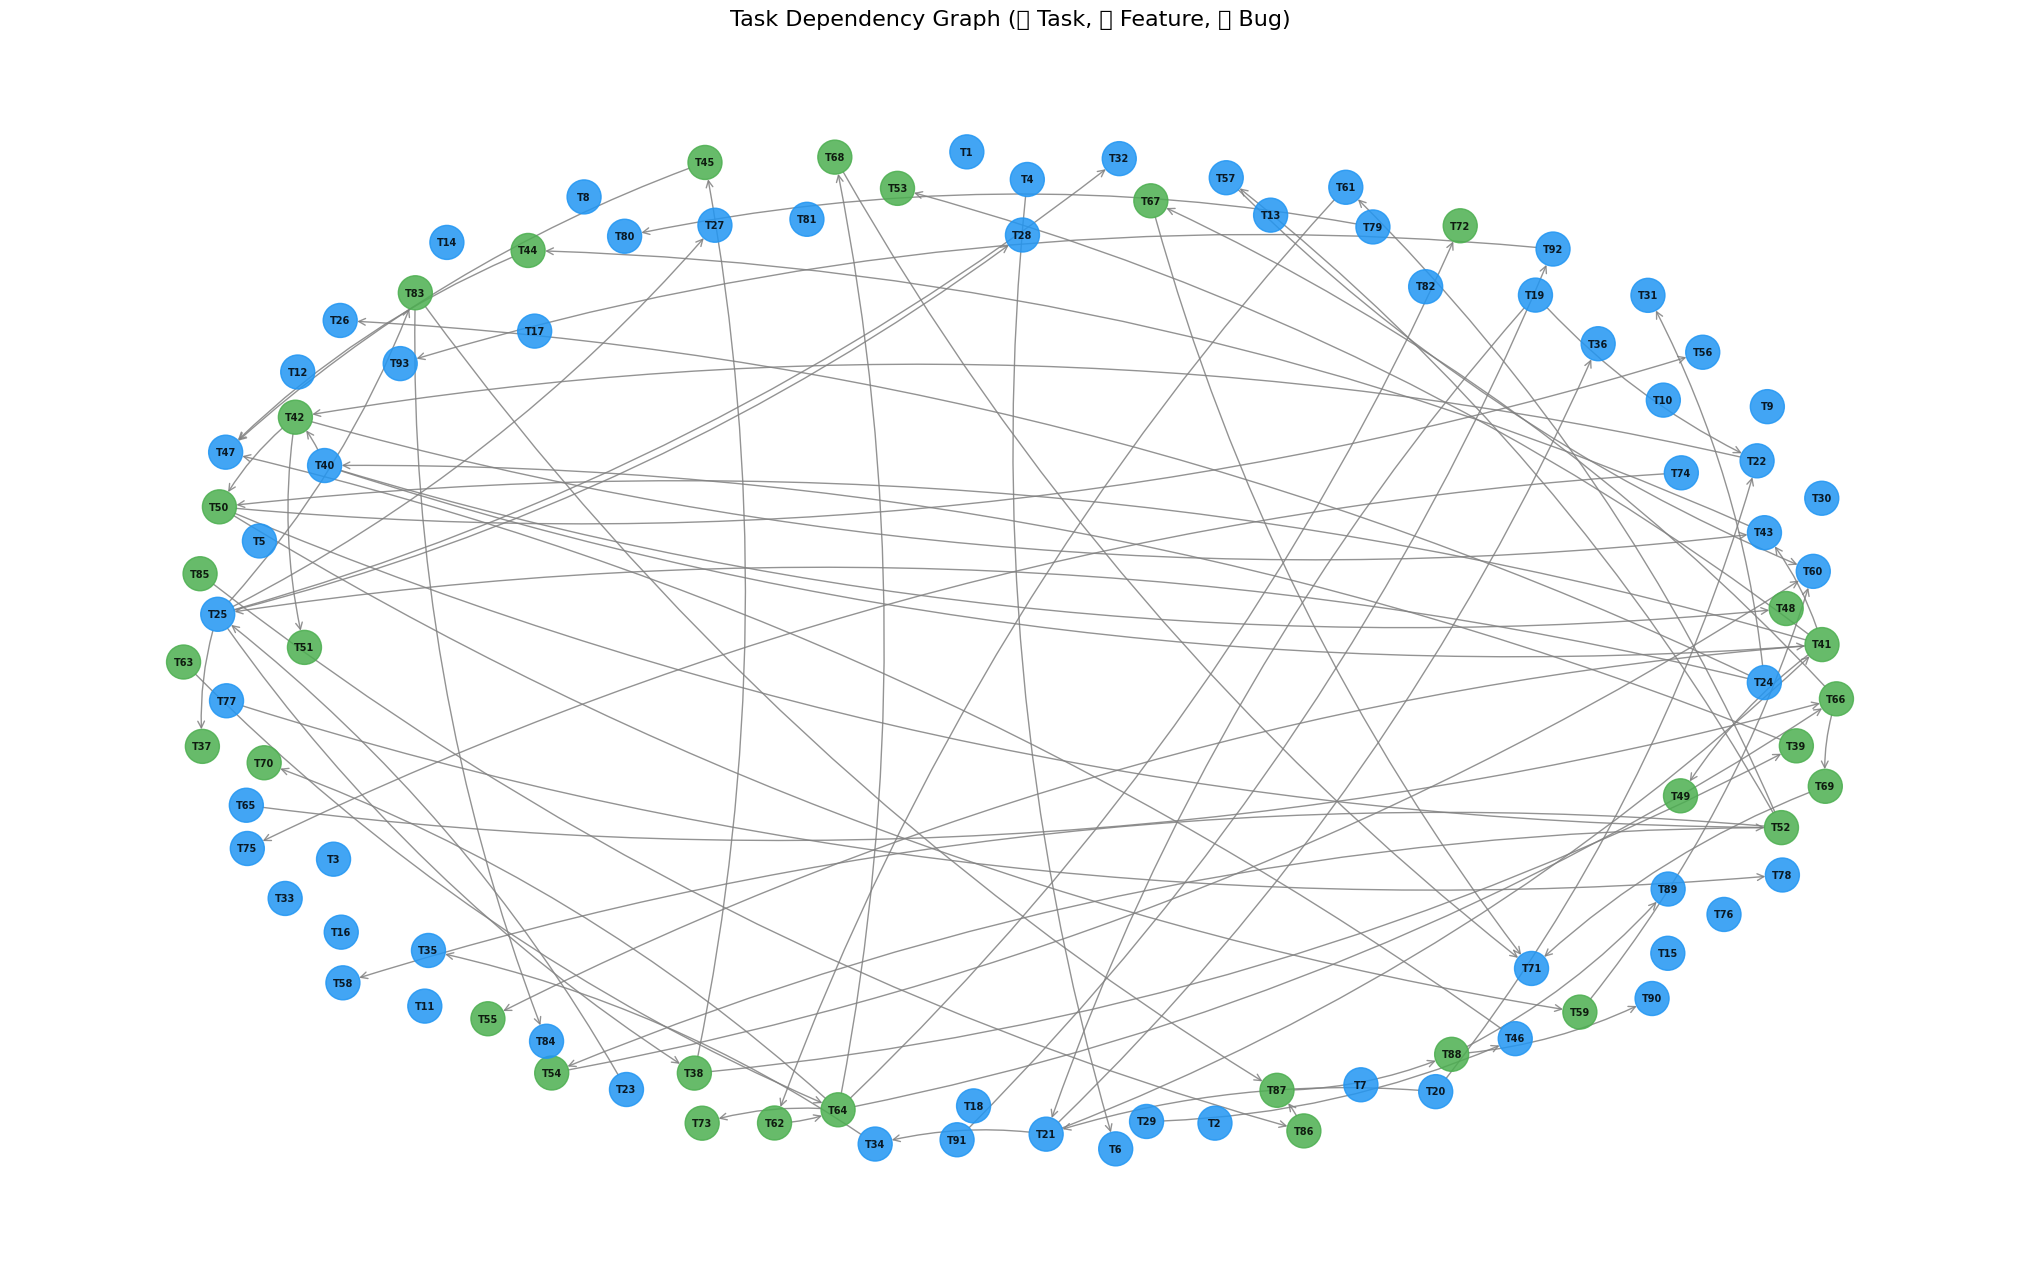


💡 Zoom in to see task keys!


In [46]:
# Visualize dependency graph (only if not too large)
if G.number_of_nodes() <= 100:
    plt.figure(figsize=(20, 12))
    
    # Use spring layout for better spacing
    try:
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
    except:
        pos = nx.shell_layout(G)
    
    # Color nodes by type
    color_map = {'Task': '#2196F3', 'Feature': '#4CAF50', 'Bug': '#FF6B6B'}
    node_colors = [color_map.get(G.nodes[node].get('type', 'Task'), '#999999') for node in G.nodes()]
    
    # Draw graph
    nx.draw(
        G,
        pos,
        node_color=node_colors,
        node_size=600,
        font_size=7,
        font_weight='bold',
        arrows=True,
        arrowsize=12,
        edge_color='gray',
        alpha=0.85,
        with_labels=True,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.1'
    )
    
    plt.title('Task Dependency Graph (🔵 Task, 🟢 Feature, 🔴 Bug)', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Zoom in to see task keys!")
else:
    print(f"⚠️ Graph too large ({G.number_of_nodes()} nodes) - skipping visualization")
    print(f"   Use Cytoscape or Gephi for large graphs")

## 7. 📦 Milestone Breakdown (Sunburst Chart)

In [47]:
# Create hierarchical data for sunburst (Milestone -> Area -> Task)
sunburst_data = []

# Group by milestone and area
for milestone in df['milestone'].unique():
    milestone_df = df[df['milestone'] == milestone]
    milestone_effort = milestone_df['effort'].sum()
    
    for area in milestone_df['area'].unique():
        area_df = milestone_df[milestone_df['area'] == area]
        area_effort = area_df['effort'].sum()
        
        for _, task in area_df.iterrows():
            sunburst_data.append({
                'labels': f"{task['key']}: {task['title'][:30]}",
                'parents': f"{milestone} - {area}",
                'values': task['effort'],
                'type': task['type']
            })
        
        sunburst_data.append({
            'labels': f"{milestone} - {area}",
            'parents': milestone,
            'values': area_effort,
            'type': 'area'
        })
    
    sunburst_data.append({
        'labels': milestone,
        'parents': '',
        'values': milestone_effort,
        'type': 'milestone'
    })

sb_df = pd.DataFrame(sunburst_data)

# Create sunburst chart
fig = px.sunburst(
    sb_df,
    names='labels',
    parents='parents',
    values='values',
    color='type',
    color_discrete_map={
        'milestone': '#FF6B6B',
        'area': '#FFA726',
        'Task': '#2196F3',
        'Feature': '#4CAF50',
        'Bug': '#EF5350'
    },
    title='PI-2026-Q1 Hierarchical Breakdown (Milestone → Area → Task)',
    height=800
)

fig.update_traces(textinfo='label+percent parent')
fig.show()

## 8. 🎯 Task Distribution (Type, Priority, Area)

In [48]:
# Create multi-chart dashboard
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('By Type', 'By Priority', 'By Area', 'By Milestone'),
    specs=[[{'type': 'pie'}, {'type': 'pie'}],
           [{'type': 'bar'}, {'type': 'bar'}]]
)

# 1. By Type
type_counts = df['type'].value_counts()
fig.add_trace(
    go.Pie(labels=type_counts.index, values=type_counts.values, 
           marker=dict(colors=['#2196F3', '#4CAF50', '#FF6B6B'])),
    row=1, col=1
)

# 2. By Priority
priority_counts = df['priority'].value_counts()
fig.add_trace(
    go.Pie(labels=priority_counts.index, values=priority_counts.values,
           marker=dict(colors=['#EF5350', '#FF9800', '#FFC107', '#8BC34A'])),
    row=1, col=2
)

# 3. By Area (effort)
area_effort = df.groupby('area')['effort'].sum().sort_values(ascending=True)
fig.add_trace(
    go.Bar(x=area_effort.values, y=area_effort.index, orientation='h',
           marker=dict(color='#4CAF50'), text=area_effort.values, textposition='outside'),
    row=2, col=1
)

# 4. By Milestone (task count)
milestone_counts = df['milestone'].value_counts().sort_values(ascending=True)
fig.add_trace(
    go.Bar(x=milestone_counts.values, y=milestone_counts.index, orientation='h',
           marker=dict(color='#2196F3'), text=milestone_counts.values, textposition='outside'),
    row=2, col=2
)

fig.update_layout(
    title_text='PI-2026-Q1 Task Distribution Dashboard',
    height=800,
    showlegend=False
)

fig.update_xaxes(title_text='Effort Points', row=2, col=1)
fig.update_xaxes(title_text='Task Count', row=2, col=2)

fig.show()

# Print summary
print("\n📊 Distribution Summary:")
print(f"\n   By Type: {dict(type_counts)}")
print(f"   By Priority: {dict(priority_counts)}")
print(f"\n   Top 3 Areas by Effort:")
top_areas = df.groupby('area')['effort'].sum().sort_values(ascending=False).head(3)
for area, effort in top_areas.items():
    print(f"      {area}: {effort} pts")


📊 Distribution Summary:

   By Type: {'Task': np.int64(62), 'Feature': np.int64(31)}
   By Priority: {'p0': np.int64(59), 'p1': np.int64(26), 'p2': np.int64(8)}

   Top 3 Areas by Effort:
      ml: 66 pts
      comic: 47 pts
      setup: 45 pts


## 9. 🚀 Export Interactive HTML

In [49]:
# Export Gantt chart as standalone HTML
fig_gantt = px.timeline(
    df,
    x_start='start_date',
    x_end='end_date',
    y='milestone',
    color='type',
    hover_data=['key', 'title', 'effort', 'priority', 'area'],
    title='PI-2026-Q1 Interactive Gantt Chart (Modular Structure)',
    color_discrete_map={
        'Task': '#2196F3',
        'Feature': '#4CAF50',
        'Bug': '#FF6B6B'
    },
    height=900
)

fig_gantt.update_yaxes(categoryorder='total ascending')
fig_gantt.update_layout(
    xaxis_title='Timeline (Feb - May 2026)',
    font=dict(size=12),
    showlegend=True
)

output_path = Path('/workspaces/morpheus/planning/pi-gantt-interactive.html')
fig_gantt.write_html(str(output_path))

print(f"✅ Exported interactive Gantt chart to: {output_path}")
print(f"   Open in browser to explore! File size: {output_path.stat().st_size / 1024:.1f} KB")

✅ Exported interactive Gantt chart to: /workspaces/morpheus/planning/pi-gantt-interactive.html
   Open in browser to explore! File size: 4745.3 KB


## 💡 Summary Statistics

In [50]:
print("\n" + "="*60)
print("📊 PI-2026-Q1 EXECUTIVE SUMMARY")
print("="*60)

print(f"\n🎯 SCOPE:")
print(f"   Total Tasks: {len(df)}")
print(f"   Total Effort: {df['effort'].sum()} points")
print(f"   Avg per Task: {df['effort'].mean():.1f} points")
print(f"   Milestones: {df['milestone'].nunique()}")
print(f"   Areas: {df['area'].nunique()}")

print(f"\n📦 BY TYPE:")
for task_type, count in df['type'].value_counts().items():
    pct = count/len(df)*100
    effort = df[df['type']==task_type]['effort'].sum()
    print(f"   {task_type}: {count} tasks ({pct:.0f}%), {effort} pts")

print(f"\n⏱️ TIMELINE:")
print(f"   Start: {df['start_date'].min().date()}")
print(f"   End: {df['end_date'].max().date()}")
print(f"   Duration: {(df['end_date'].max() - df['start_date'].min()).days} days")
print(f"   Iterations: {len(iterations_keys)}")

print(f"\n⚠️ CAPACITY ANALYSIS:")
total_capacity = capacity * len(iterations_keys)
total_effort = df['effort'].sum()
utilization = total_effort / total_capacity * 100

print(f"   Total Capacity: {total_capacity} pts ({len(iterations_keys)} × {capacity})")
print(f"   Total Effort: {total_effort} pts")
print(f"   Overall Utilization: {utilization:.0f}%")

over_capacity = iteration_effort[iteration_effort['over_capacity'] > 0]
if len(over_capacity) > 0:
    print(f"\n   🚨 CRITICAL: {len(over_capacity)}/{len(iteration_effort)} iterations over capacity")
    print(f"   Total overage: {iteration_effort['over_capacity'].sum():.0f} pts")
    print(f"   Worst iteration: {iteration_effort.loc[iteration_effort['over_capacity'].idxmax(), 'iteration']} "
          f"(+{iteration_effort['over_capacity'].max():.0f} pts over)")
    print(f"\n   ⚠️ RECOMMENDATION: Rebalance tasks or increase capacity")
else:
    print(f"   ✅ All iterations within capacity")

print(f"\n🕸️ DEPENDENCIES:")
print(f"   Total dependencies: {G.number_of_edges()}")
print(f"   Is DAG: {nx.is_directed_acyclic_graph(G)}")
if out_degree:
    max_blocker = max(out_degree.items(), key=lambda x: x[1])
    if max_blocker[1] > 0:
        print(f"   Biggest blocker: {max_blocker[0]} ({max_blocker[1]} tasks depend on it)")

print(f"\n🎯 TOP 3 MILESTONES (by effort):")
top_milestones = df.groupby('milestone')['effort'].sum().sort_values(ascending=False).head(3)
for i, (milestone, effort) in enumerate(top_milestones.items(), 1):
    task_count = len(df[df['milestone']==milestone])
    print(f"   {i}. {milestone}: {effort} pts ({task_count} tasks)")

print("\n" + "="*60)


📊 PI-2026-Q1 EXECUTIVE SUMMARY

🎯 SCOPE:
   Total Tasks: 93
   Total Effort: 333 points
   Avg per Task: 3.6 points
   Milestones: 8
   Areas: 9

📦 BY TYPE:
   Task: 62 tasks (67%), 216 pts
   Feature: 31 tasks (33%), 117 pts

⏱️ TIMELINE:
   Start: 2026-02-10
   End: 2026-05-18
   Duration: 97 days
   Iterations: 7

⚠️ CAPACITY ANALYSIS:
   Total Capacity: 210 pts (7 × 30)
   Total Effort: 333 pts
   Overall Utilization: 159%

   🚨 CRITICAL: 6/7 iterations over capacity
   Total overage: 123 pts
   Worst iteration: I2 (+42 pts over)

   ⚠️ RECOMMENDATION: Rebalance tasks or increase capacity

🕸️ DEPENDENCIES:
   Total dependencies: 75
   Is DAG: True
   Biggest blocker: T25 (6 tasks depend on it)

🎯 TOP 3 MILESTONES (by effort):
   1. M1 - Backend Services: 70 pts (19 tasks)
   2. M2 - ML Training & Development: 63 pts (13 tasks)
   3. M6 - Commerce & Distribution: 60 pts (17 tasks)



## 🔍 Weryfikacja T24 - AI-aware Duration

Sprawdzenie czy T24 ma teraz 2 dni zamiast 7 dni (po naprawie)

In [53]:
# Check T24 specifically
t24_data = df[df['key'] == 'T24'].iloc[0]

print("T24: Supabase Database Setup with RLS")
print("="*60)
print(f"\n📊 Estimation Data:")
print(f"   Effort (story points): {t24_data['effort']} pts")
print(f"   AI-aware estimated_days: {t24_data['estimated_days']:.1f} days")
print(f"   Old calculation (effort * 1.5): {t24_data['effort'] * 1.5:.1f} days")

print(f"\n📅 Scheduled Dates:")
print(f"   Start: {t24_data['realistic_start'].date()}")
print(f"   End: {t24_data['realistic_end'].date()}")
print(f"   Actual Duration: {(t24_data['realistic_end'] - t24_data['realistic_start']).days + 1} days")

print(f"\n👨‍💻 Assignment:")
print(f"   Developer: {t24_data['assigned_dev']}")
print(f"   Iteration: {t24_data['iteration']}")
print(f"   Milestone: {t24_data['milestone']}")

# Verify duration matches estimated_days
expected = int(t24_data['estimated_days'])
actual = (t24_data['realistic_end'] - t24_data['realistic_start']).days + 1

if actual == expected:
    print(f"\n✅ CORRECT: Actual duration ({actual} days) matches AI-aware estimate ({expected} days)")
else:
    print(f"\n❌ MISMATCH: Actual duration ({actual} days) ≠ AI-aware estimate ({expected} days)")
    print(f"   Difference: {abs(actual - expected)} days")


T24: Supabase Database Setup with RLS

📊 Estimation Data:
   Effort (story points): 5 pts
   AI-aware estimated_days: 2.0 days
   Old calculation (effort * 1.5): 7.5 days

📅 Scheduled Dates:
   Start: 2026-02-14
   End: 2026-02-15
   Actual Duration: 2 days

👨‍💻 Assignment:
   Developer: 1
   Iteration: I2
   Milestone: M1 - Backend Services

✅ CORRECT: Actual duration (2 days) matches AI-aware estimate (2 days)
